# Herron Topic 2 - Trading Strategies

This notebook covers trading strategies based on technical analysis in three parts:

1. What is technical analysis?
1. Why might trading strategies based on technical analysis work (or not work)?
1. Implement a simple moving average (SMA) trading strategy

I based this lecture notebook on [chapter 12 of Ivo Welch's *Corporate Finance* textbook](https://book.ivo-welch.info/read/source5.mba/12-effbehav.pdf) and chapter 2 of [Eryk Lewinson's *Python for Finance Cookbook*](https://onesearch.library.northeastern.edu/permalink/01NEU_INST/i2gqis/alma9952082522901401).
The practice notebook will cover several other trading strategies based on technical analysis.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import statsmodels.api as sm
import yfinance as yf

In [2]:
%precision 4
pd.options.display.float_format = '{:.4f}'.format
%config InlineBackend.figure_format = 'retina'

## What is technical analysis?

[Technical analysis](https://en.wikipedia.org/wiki/Technical_analysis) is a methodology that analyzes past market data (e.g., past prices and volume) in an attempt to forecast future price movements.
If technical analysis can predict future price movements, the market is not weak-form efficient.
Ivo Welch provides the three degrees of market efficiency in section 12.2 of [chapter 12 of his (free) *Corporate Finance* textbook](https://book.ivo-welch.info/read/source5.mba/12-effbehav.pdf):

> The Traditional Classification
The traditional definition of market efficiency focuses on information. In the traditional classification, market efficiency comes in one of three primary degrees: weak,
semi-strong, and strong.
>
> **Weak market efficiency** says that all information in past prices is reflected in today’s
stock prices so that technical analysis (trading based solely on historical price
patterns) cannot be used to beat the market. Put differently, the market is the
best technical analyst.
>
> **Semistrong market efficiency** says that all public information is reflected in today’s
stock prices, so that neither fundamental trading (based on underlying firm
fundamentals, such as cash flows or discount rates) nor technical analysis can
be used to beat the market. Put differently, the market is both the best technical
and the best fundamental analyst.
>
> **Strong market efficiency** says that all information, both public and private, is reflected in today’s stock prices, so that nothing — not even private insider
information — can be used to beat the market. Put differently, the market is
the best analyst and cannot be beat.
> 
> In this traditional classification, all finance professors nowadays believe that most U.S. financial markets are not strong-form efficient: Insider trading may be illegal, but it works. However, there are still arguments as to which markets are only semi-strong-form efficient or even only weak-form efficient.

Section 12.2 goes on to provide Welch's own taxonomy of true, firm, mild, and nonbelievers in market efficiency.
Chapter 12 summarizes market efficiency, classical finance, behavioral finance, arbitrage, limits to arbitrage, and their consequences for managers and investors.
We will focus on technical analysis in this notebook, but chapter 12 is excellent.

## Why might trading strategies based on technical analysis work or not?

### ...Work?

Technical analysis relies on a few ideas:

1. Market prices and volume reflect all relevant information, so we can focus on past prices and volume instead of fundamentals and news.
1. Market prices move in trends and patterns driven by market participants.
1. These trends and patterns tend to repeat themselves because market participants create them.

### ...Or Not?

The logic above is reasonable.
However, if past market prices reflect all relevant information, they should also reflect any prices trends they predict.
Therefore, any patterns should be self-defeating, and market prices should follow [a random walk](https://en.wikipedia.org/wiki/Random_walk_hypothesis).
As well, the signal-to-noise ratio in market prices is high!
Still, technical analysis provides an opportunity to learn how to implement and back-test trading strategies in Python.

#### A Random Walk

In a random walk, the price tomorrow equals the price today plus a tiny drift plus noise.
In math terms, a random walk is $$P_{t} = \rho P_{t-1} + m P_{t-1} + \varepsilon_t$$ where $m$ is a small drift term and $E[\varepsilon] = 0$.
If $\rho > 1$, prices would quickly increase, and, if $\rho < 1$, prices would quickly decrease.
Let us examine the historical record.

In [3]:
ff = (
    pdr.DataReader(
        name='F-F_Research_Data_Factors_daily',
        data_source='famafrench',
        start='1900'
    )
    [0]
    .assign(Mkt=lambda x: x['Mkt-RF'] + x['RF'])
    .div(100)
)

ff.head()

C:\Users\r.herron\AppData\Local\Temp\ipykernel_22728\2916005334.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  pdr.DataReader(


,Mkt-RF,SMB,HML,RF,Mkt
Date,,,,,
1926-07-01,0.0010,-0.0025,-0.0027,0.0001,0.0011
1926-07-02,0.0045,-0.0033,-0.0006,0.0001,0.0046
1926-07-06,0.0017,0.0030,-0.0039,0.0001,0.0018
1926-07-07,0.0009,-0.0058,0.0002,0.0001,0.0010
1926-07-08,0.0021,-0.0038,0.0019,0.0001,0.0022


We can use market returns to impute market prices relative to the last day of June 1926.

In [4]:
price = ff['Mkt'].add(1).cumprod()

price.tail()

Date
2024-01-25   11969.2170
2024-01-26   11969.4564
2024-01-29   12073.8301
2024-01-30   12060.7903
2024-01-31   11853.5860
Name: Mkt, dtype: float64

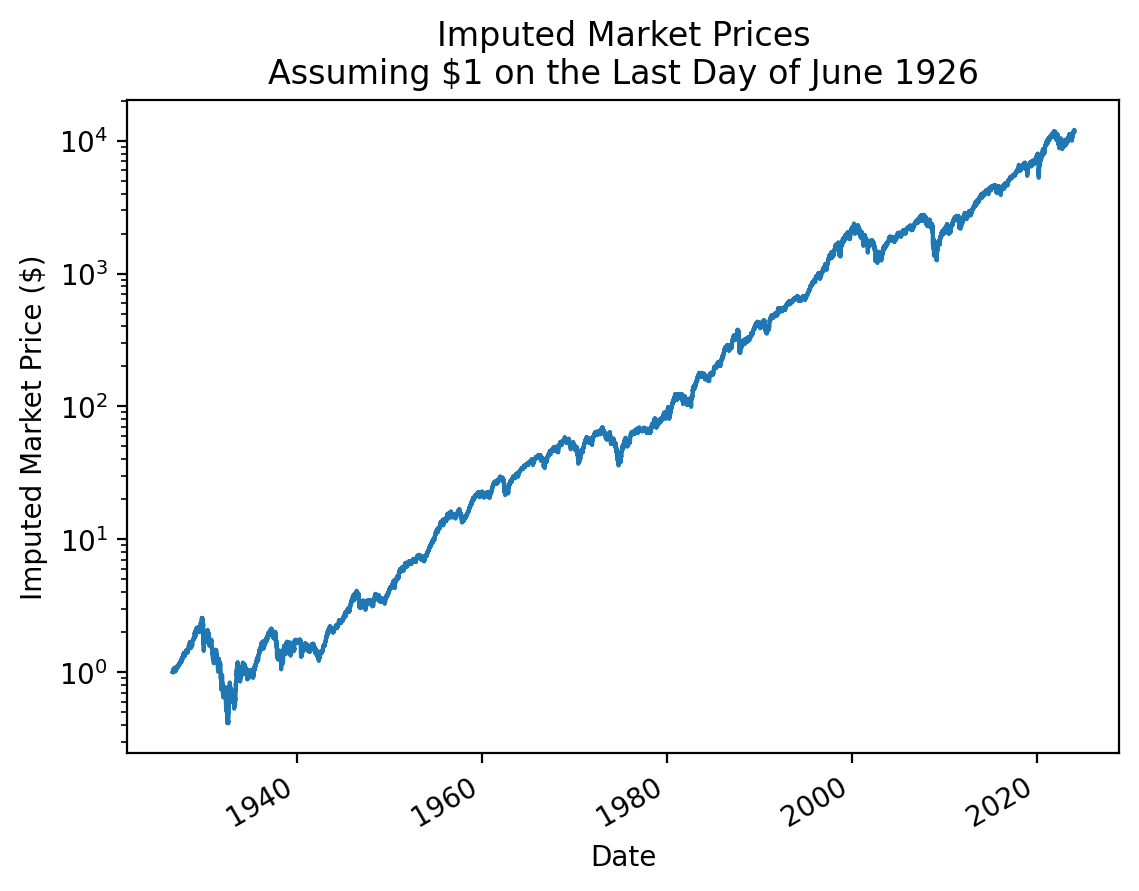

In [5]:
price.plot()
plt.title('Imputed Market Prices\nAssuming $1 on the Last Day of June 1926')
plt.ylabel('Imputed Market Price ($)')
plt.semilogy()
plt.show()

We need lagged prices to estimate $\rho$.
We will add 10 lags of $P$ to help us understand the relation between past and future prices.

In [6]:
price_lags = (
    pd.concat(
        objs=[price.shift(t) for t in range(11)],
        keys=[f'Lag {t}' for t in range(11)],
        names=['Price'],
        axis=1,
    )
)

price_lags.head()

Price,Lag 0,Lag 1,Lag 2,Lag 3,Lag 4,Lag 5,Lag 6,Lag 7,Lag 8,Lag 9,Lag 10
Date,,,,,,,,,,,
1926-07-01,1.0011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-07-02,1.0057,1.0011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-07-06,1.0075,1.0057,1.0011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-07-07,1.0085,1.0075,1.0057,1.0011,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-07-08,1.0107,1.0085,1.0075,1.0057,1.0011,NaN,NaN,NaN,NaN,NaN,NaN


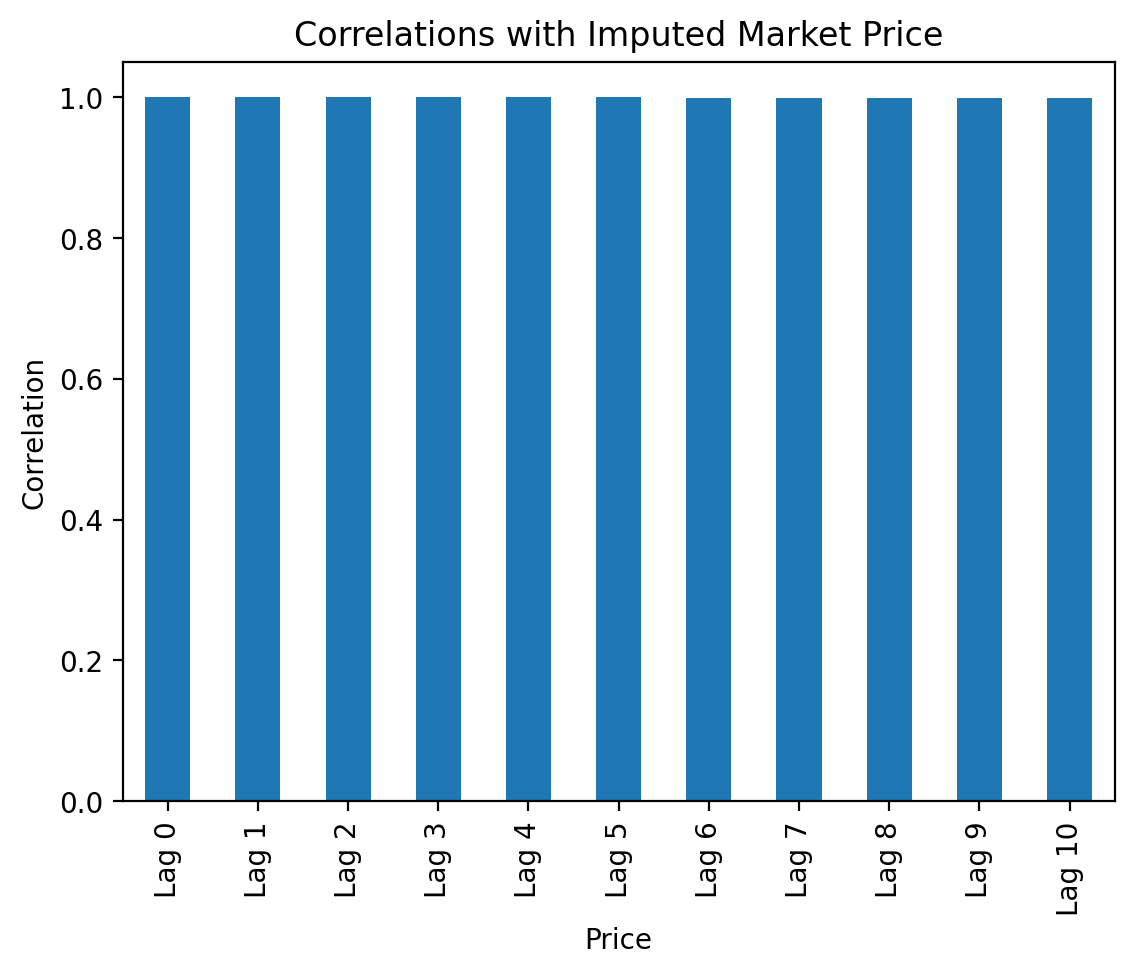

In [7]:
(
    price_lags
    .dropna()
    .corr()
    .loc['Lag 0']
    .plot(kind='bar')
)
plt.title('Correlations with Imputed Market Price')
plt.ylabel('Correlation')
plt.show()

But these are *pairwise* correlations.
If we estimate *conditional* correlations, we see that most of the price information is in the first lag!

In [8]:
_ = price_lags.dropna()
y = _['Lag 0']
X = _.drop('Lag 0', axis=1).pipe(sm.add_constant)
model = sm.OLS(endog=y, exog=X)
fit = model.fit(cov_type='HAC', cov_kwds={'maxlags': 10})
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Lag 0   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.848e+06
Date:                Fri, 15 Mar 2024   Prob (F-statistic):               0.00
Time:                        11:16:38   Log-Likelihood:            -1.2242e+05
No. Observations:               25660   AIC:                         2.449e+05
Df Residuals:                   25649   BIC:                         2.450e+05
Df Model:                          10                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0590      0.143      0.412      0.680      -0.222       0.340
Lag 1          0.9473      0.035     27.080      0.000       0.879       1.016
Lag 2          0.0778      0.060      1.287      0.198      -0.041       0.196
Lag 3         -0.0342      0.038     -0.897      0.369      -0.109       0.041
Lag 4         -0.0275      0.043     -0.642      0.521      -0.112       0.057
Lag 5          0.0442      0.040      1.108      0.268      -0.034       0.122
Lag 6         -0.0657      0.043     -1.539      0.124      -0.149       0.018
Lag 7          0.1271      0.050      2.541      0.011       0.029       0.225
Lag 8         -0.1299      0.056     -2.315      0.021      -0.240      -0.020
Lag 9          0.1485      0.048      3.095      0.002       0.054       0.242
Lag 10        -0.0871      0.032     -2.705      0.007      -0.150      -0.024
==============================================================================
Omnibus:                    15996.444   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4983693.037
Skew:                          -1.823   Prob(JB):                         0.00
Kurtosis:                      71.176   Cond. No.                     8.90e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 10 lags and without small sample correction
[2] The condition number is large, 8.9e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

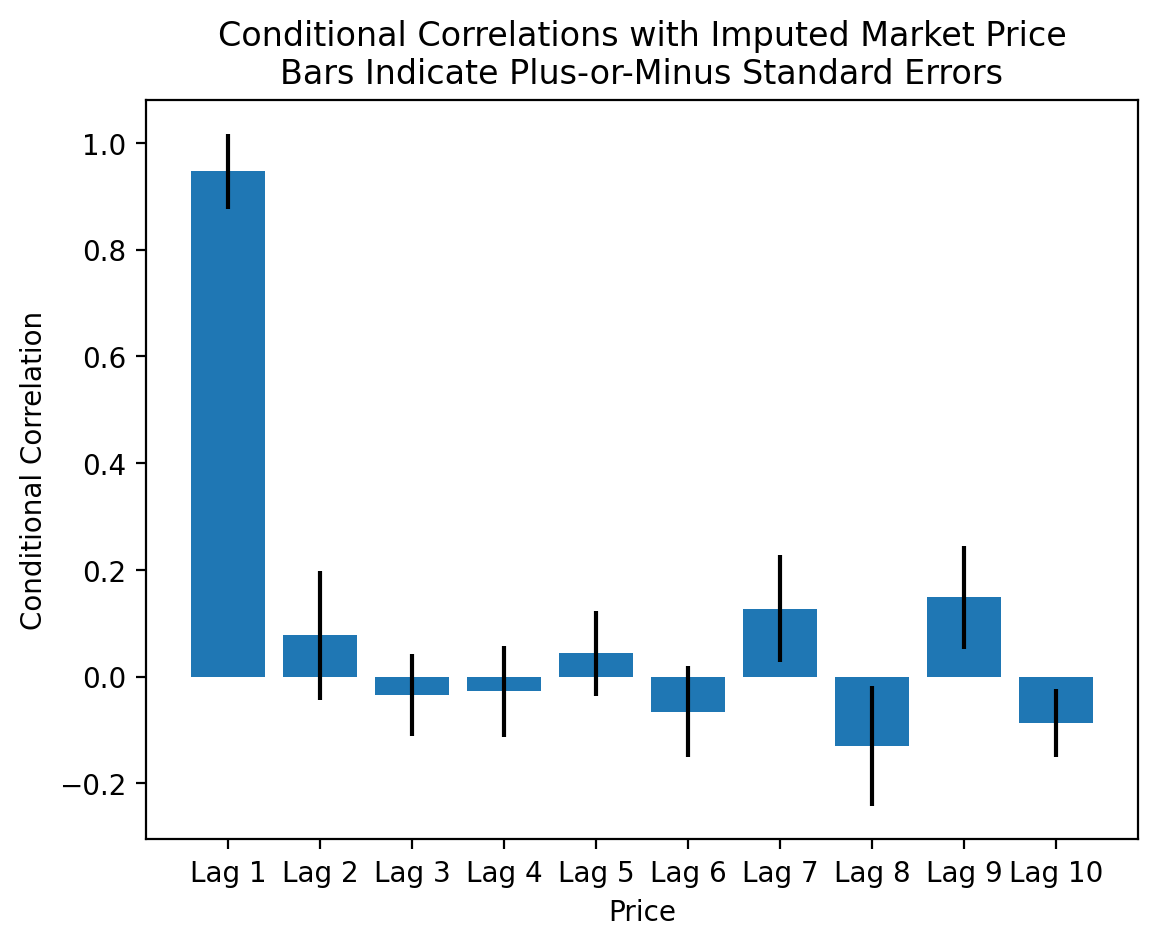

In [10]:
plt.bar(
    x=price_lags.columns[1:],
    height=fit.params[1:],
    yerr=2*fit.bse[1:]
)
plt.title('Conditional Correlations with Imputed Market Price\nBars Indicate Plus-or-Minus Standard Errors')
plt.ylabel('Conditional Correlation')
plt.xlabel('Price')
plt.show()

#### Signal-to-Noise Ratio

Recall, we can express a random walk as $P_{t} = \rho P_{t-1} + m P_{t-1} + \varepsilon_t$.
Since $\rho = 1$, we can subtract $P_{t-1}$ from both sides, then divide by $P_{t-1}$ on both sides.
This transformation expresses a random walk in terms of returns: $r_{t-1,t} = m + e_t$, where $E[e_t] = 0$ and $SD[e_t] = s$, so $E[r_{t-1, t}] = m$.
We can think of the signal-to-noise ratio as $\frac{m}{s}$.
How high is this ratio?

In [11]:
m, s = ff['Mkt'].mean(), ff['Mkt'].std()

Here $m$ is about 4 basis points per day!

In [12]:
m

0.0004

However, $s$ is about 108 basis points per day!

In [13]:
s

0.0108

In [14]:
m/s

0.0392

Recall that means grow linearly with time and standard deviations growth with the square-root of time.
So, if we want $\sqrt{t} \times \frac{m}{s} \geq 2$, we need $t \geq \left(2 \times \frac{s}{m} \right)^2$ days!
Even with market portfolio noise, which is diversified and low, we needat least a decade!
During this decade, the true values of $m$ and $s$ can change!

In [15]:
(2 * s / m)**2 / 252

10.3088

## Implement a simple moving average (SMA) trading strategy

The goal of technical analysis is to "buy low, and sell high."
The $n$-day SMA reduces noise in market prices, removing market fluctuations and providing estimates of "true" prices.
While the market price is *above* the SMA, the SMA *rises.*
While the market price is *below* the SMA, the SMA *falls.*
So, if we buy the stock as it cross the SMA from below and sell the stock as it crosses the SMA from above, we mechanically buy low and sell high!
Here, we will implement a long-only 20-day SMA (SMA(20)) strategy with Bitcoin:

1. Buy when the closing price crosses SMA(20) from below
2. Sell when the closing price crosses SMA(20) from above
3. No short-selling

Because we will not short sell the stock, we can simplify this strategy to "long if above SMA(20), otherwise neutral".
First, we will need Bitcoin returns data.

In [16]:
btc = (
    yf.download(tickers='BTC-USD')
    .assign(Return = lambda x: x['Adj Close'].pct_change())
    .rename_axis(columns='Variable')
)

btc.head()

[*********************100%%**********************]  1 of 1 completed


Variable,Open,High,Low,Close,Adj Close,Volume,Return
Date,,,,,,,
2014-09-17,465.8640,468.1740,452.4220,457.3340,457.3340,21056800,NaN
2014-09-18,456.8600,456.8600,413.1040,424.4400,424.4400,34483200,-0.0719
2014-09-19,424.1030,427.8350,384.5320,394.7960,394.7960,37919700,-0.0698
2014-09-20,394.6730,423.2960,389.8830,408.9040,408.9040,36863600,0.0357
2014-09-21,408.0850,412.4260,393.1810,398.8210,398.8210,26580100,-0.0247


Next we:

1. Use `.rolling(20).mean()` to add a `SMA20` column containing SMA(20) to our `btc` data frame
1. Use `np.select()` to add a `Position` column containing:
    1. `1` (long) when the adjusted close is greater than SMA(20)
    1. `0` (neutral) when the adjusted close is less than (or equal to) SMA(20)
    1. We could use `np.where()` instead of `np.select()`, but using `np.select()` provides a more flexible framework for more complex examples
    1. **We use `.shift()` to compare yesterday's closing prices, avoiding a look-ahead bias**
1. Add a `Strategy` column containing:
    1. `Return` if `Position == 1`
    1. `0` if `Position == 0`
    1. We could earn the risk-free rate instead of 0 percent, but earning 0 percent simplifies this example

In [19]:
btc = (
    btc
    .assign(
        SMA20 = lambda x: x['Adj Close'].rolling(20).mean(),
        Position = lambda x: np.select(
            condlist=[x['Adj Close'].shift() > x['SMA20'].shift(), x['Adj Close'].shift() <= x['SMA20'].shift()],
            choicelist=[1, 0],
            default=np.nan
        ),
        Strategy = lambda x: x['Position'] * x['Return']
    )
)

btc.head(30)

Variable,Open,High,Low,Close,Adj Close,Volume,Return,SMA20,Position,Strategy
Date,,,,,,,,,,
2014-09-17,465.8640,468.1740,452.4220,457.3340,457.3340,21056800,NaN,NaN,NaN,NaN
2014-09-18,456.8600,456.8600,413.1040,424.4400,424.4400,34483200,-0.0719,NaN,NaN,NaN
2014-09-19,424.1030,427.8350,384.5320,394.7960,394.7960,37919700,-0.0698,NaN,NaN,NaN
2014-09-20,394.6730,423.2960,389.8830,408.9040,408.9040,36863600,0.0357,NaN,NaN,NaN
2014-09-21,408.0850,412.4260,393.1810,398.8210,398.8210,26580100,-0.0247,NaN,NaN,NaN
2014-09-22,399.1000,406.9160,397.1300,402.1520,402.1520,24127600,0.0084,NaN,NaN,NaN
2014-09-23,402.0920,441.5570,396.1970,435.7910,435.7910,45099500,0.0836,NaN,NaN,NaN
2014-09-24,435.7510,436.1120,421.1320,423.2050,423.2050,30627700,-0.0289,NaN,NaN,NaN
2014-09-25,423.1560,423.5200,409.4680,411.5740,411.5740,26814400,-0.0275,NaN,NaN,NaN


I find it helpful to plot `Adj Close`, `SMA20`, and `Position` for a sort window with one or more crossings.

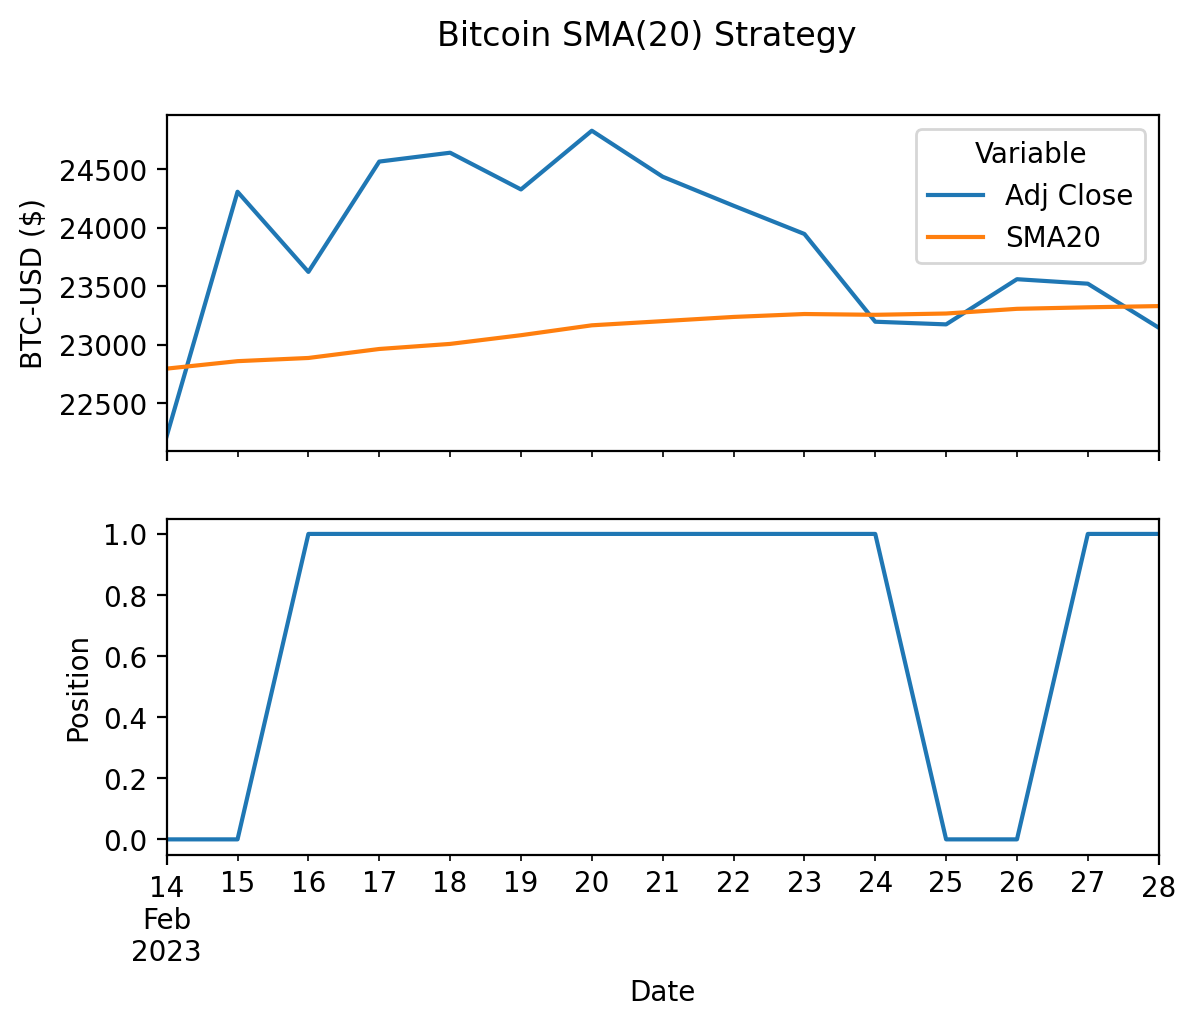

In [20]:
fig, ax = plt.subplots(2, 1, sharex=True)
_ = btc.loc['2023-02'].iloc[-15:]
_[['Adj Close', 'SMA20']].plot(ax=ax[0], ylabel='BTC-USD ($)')
_[['Position']].plot(ax=ax[1], ylabel='Position', legend=False)
plt.suptitle('Bitcoin SMA(20) Strategy')
plt.show()

We can compare the long-run performance of buy-and-hold and SMA(20).

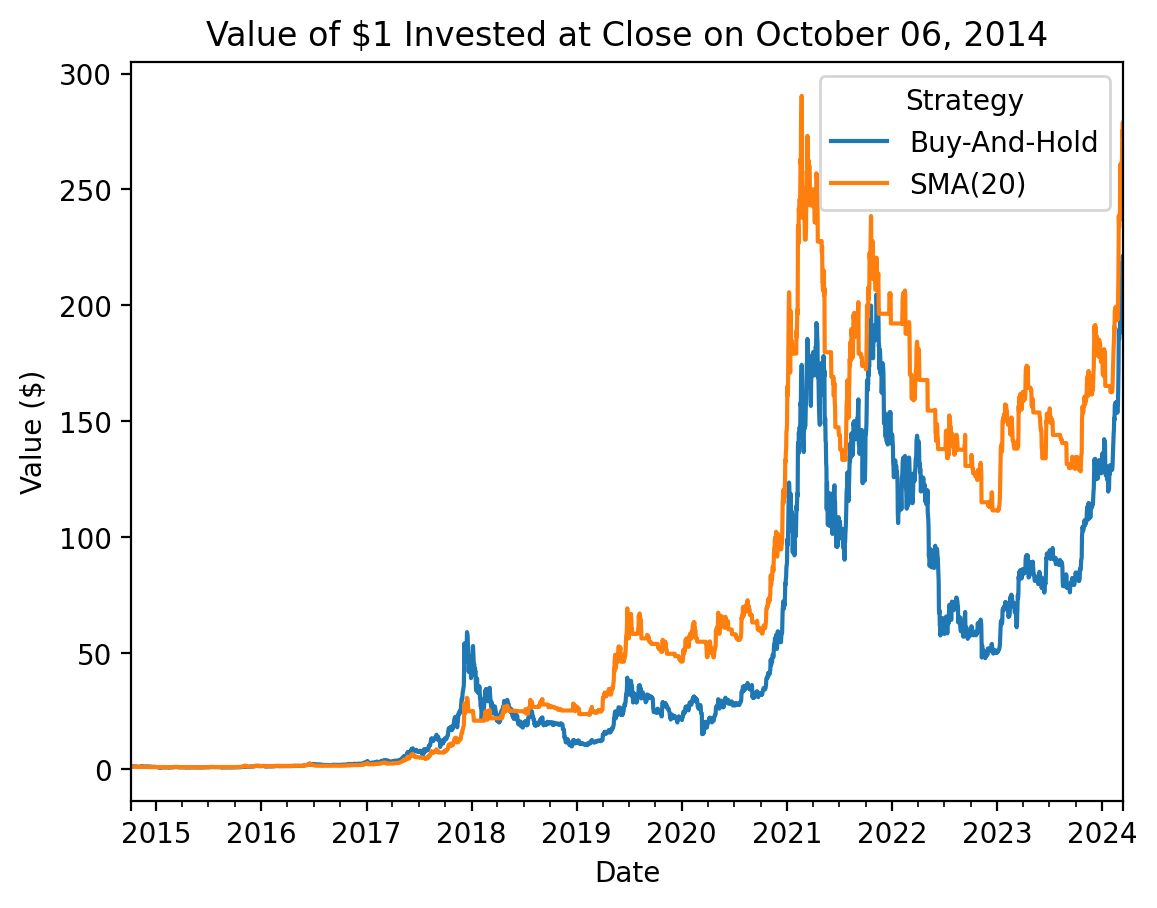

In [21]:
_ = btc[['Return', 'Strategy']].dropna()

(
    _
    .add(1)
    .cumprod()
    .rename_axis(columns='Strategy')
    .rename(columns={'Return': 'Buy-And-Hold', 'Strategy': 'SMA(20)'})
    .plot()
)
plt.ylabel('Value ($)')
plt.title(f'Value of $1 Invested at Close on {_.index[0] - pd.offsets.Day(1):%B %d, %Y}')
plt.show()

In the practice notebook, we will dig deeper on this strategy and others.